# Variational Autoencoder
The [Basic Concepts](./Basic%20Concepts.ipynb) notebook serves as an introduction to variational inference by means of toy examples. The purpose of this notebook is to demonstrate the application of variational inference in tackling a real life problem - that of generating natural images. The broad problem that is being addessed here is generative modeling. This notebook is based on the paper by ([Kingma et al. 2013](https://arxiv.org/pdf/1312.6114)).

## Generative Models
Given a dataset, $\mathcal{D} = \{x^{(1)}, x^{(2)}, ..., x^{(N)}\}$, generative models are probabilistic models that can be used to generate data "similar" to that in $\mathcal{D}$. The aim is to model $p(x)$ using $\mathcal{D}$ and then subsequently generate "similar" data by sampling from $p(x)$. For example $\mathcal{D}$ might contain images of handwritten digits and a generative model will find a $p(x)$ such that a sample drawn from $p(x)$ looks visually similar to one of the handwritten digit.

In this notebook we will focus on a generative model for images. In such a case, each element $x \in \mathcal{D}$ will be an image, thus $x$ can be viewed as a random vector. If we have a $28\times28$ single channel image then $x$ is a $784$ dimensional vector. Due to the high dimensionality of data modelling $p(x)$ directly is very challenging. Different components of $x$ interact with each other in complicated ways. For example adjacent pixels tend to have similar intensity values. 

Due to these interactions one can not make the simplifying independence assumption among the components of $x$. One approach is to use latent variables to model complicated dependencies among input data while still keeping the model tractible.
![Latent Variables](./images/latent_variables.jpg)
<center>**Figure 1: Latent Variable Model**</center>

For example, in the graphical model shown in figure 1, $x \in \mathbb{R}^d$ are observed variables and $z \in \mathbb{R}^m$ are latent variables. Different components of $x$ are not independent. However given the values of all $z_i$'s the components of $x$ are conditionally independent of each other. Since $z_i$'s are not observed this allows the model to represent complicated dependencies among the observed data variables. The distribution $p(x_j|z)$ must be learned from the data for $j = 1, 2, ..., d$. This is easier to learn in most cases as compared to learning $p(x)$ directly. The assumption of conditional independence is more practical as compared to the assumption of mutual independence among components of $x$.

## Problem Setup
We are given a dataset $\mathcal{D} = \{x^{(1)}, x^{(2)}, ..., x^{(N)}\}$, such that each $x \in \mathcal{D}$ is an image. All the images in the dataset are assumed to have the same dimensions. We assume that the images in $\mathcal{D}$ were generated using the following generative process:
![Image Generation](./images/generation.jpg)
<center>**Figure 2: Image Generation Process**</center>

To generate an image $x$, first the corresponding latent variable $z$ is sampled from $p_\theta(z)$. Then conditioned on $z$, the image $x$ is sampled from $p_\theta(x|z)$. $\theta$ represents the parameters of the distribution. The actual generation process will have an optimal value of $\theta$. We will refer to this optimal value as $\theta^*$. In order to generate new samples we need to find $\theta^*$.

There are no labels attached to the images hence we operate in an unsupervised fashion.

## Optimization Problem
The objective is to find a setting of parameters which maximizes the log probability of observed data. Assuming that the points in $\mathcal{D}$ are iid, we wish to optimize the following function:
\begin{align}
    \sum_{i=1}^{N} \log p(x^{(i)}; \theta) &= \sum_{i=1}^{N} \log \frac{p(x^{(i)}, z; \theta)}{p(z|x^{(i)}; \theta)} \\
    &= \sum_{i=1}^{N} \log \frac{p(x^{(i)}|z; \theta) p(z; \theta)}{p(z|x^{(i)}; \theta)} \\
\end{align}

This equation holds for any value of latent variable $z$. The posterior distribution $p(z|x; \theta)$ is intractible and so by following the variational inference recepie outlined in [Basic Concepts](./Basic%20Concepts.ipynb) notebook we approximate it with a parameterised probability distribution $q(z | x ; \phi)$. The following equations hold:
\begin{align}
    \sum_{i=1}^{N} \log p(x^{(i)}; \theta) &= \sum_{i=1}^{N} \log \frac{p(x^{(i)}|z; \theta) p(z; \theta) q(z | x^{(i)} ; \phi)}{p(z|x^{(i)}; \theta) q(z | x^{(i)} ; \phi)} \\
    &= \sum_{i=1}^{N} \sum_{z} q(z | x^{(i)} ; \phi) \Big( \log \frac{p(x^{(i)}|z; \theta) p(z; \theta) q(z | x^{(i)} ; \phi)}{p(z|x^{(i)}; \theta) q(z | x^{(i)} ; \phi)} \Big) \\
    &= \sum_{i=1}^{N} \Big( \sum_{z} q(z | x^{(i)} ; \phi) \log \frac{p(x^{(i)}|z; \theta) p(z; \theta)}{q(z | x^{(i)} ; \phi)} + \sum_{z} q(z | x^{(i)} ; \phi) \log \frac{p(z|x^{(i)}; \theta)}{q(z | x^{(i)} ; \phi)} \Big) \\
    &= \sum_{i=1}^{N} \Big(E_{z \sim q(.;x^{(i)}, \phi)} [\log p(x^{(i)}|z; \theta) + \log p(z; \theta) - \log q(z | x^{(i)} ; \phi)] + KL(q, p | x^{(i)}, \theta, \phi) \Big) \\
\end{align}

Since KL divergence is always $\geq 0$, we get:
\begin{align}
    \sum_{i=1}^{N} \log p(x^{(i)}; \theta) &\geq \sum_{i=1}^{N} E_{z \sim q(.;x^{(i)}, \phi)} [\log p(x^{(i)}|z; \theta) + \log p(z; \theta) - \log q(z | x^{(i)} ; \phi)] = \mathcal{L}(\theta, \phi)\\
\end{align}

We will maximize $\mathcal{L}(\theta, \phi)$. The following equation can be obtained easily by rearranging the terms in the previous equation:

\begin{equation}
    \mathcal{L}(\theta, \phi) = \sum_{i=1}^{N} \Big(E_{z \sim q(z|x^{(i)}; \phi)} [\log p(x^{(i)}|z; \theta)] - KL[q(z | x^{(i)} ; \phi) || p(z; \theta)] \Big)
\end{equation}

The second term of this equation forces the distribution $q(z|x)$ to be close to the prior $p(z)$. The first term forces $\theta$ and $\phi$ to be adjusted in such a way that the probability of observed data given the sampled value of $z$ is high.

In order to solve this optimization problem we need to evaluate $\nabla_\phi \mathcal{L}(\theta, \phi)$. One can usually obtain an analytical expression for the KL divergence term and hence differentiating that part of $\mathcal{L}(\theta, \phi)$ is easy. The gradient of first term with respect to $\phi$ can be found using the Score Function (SF) estimator:
\begin{equation}
    \nabla_\phi E_{z \sim q(z|x^{(i)}; \phi)} [\log p(x^{(i)}|z; \theta)] = E_{z \sim q(z|x^{(i)}; \phi)} [\log p(x^{(i)}|z; \theta) \nabla_\phi \log q(z|x^{(i)}; \phi)] 
\end{equation}

This estimator has a high variance and hence is not practical. One approach is to use the reparameterisation trick ([Kingma et al. 2013](https://arxiv.org/pdf/1312.6114)). The basic idea here is to represent $z$ as a deterministic function of $\phi$ and another random variable $\epsilon$, i.e. $z=g(\phi, \epsilon)$ where $\epsilon \sim p(\epsilon)$. Now the first term in the likelihood function can be written as: $E_{\epsilon \sim p(\epsilon)}[\log p(x^{(i)}|g(\phi, \epsilon); \theta)]$. Given this expression, one can employ the Pathwise Derivative (PD) estimator to calculate the gradient of first term with respect to $\phi$ as: 
\begin{equation}
\nabla_\phi E_{\epsilon \sim p(\epsilon)}[\log p(x^{(i)}|g(\phi, \epsilon))] = E_{\epsilon \sim p(\epsilon)}[\nabla_\phi \log p(x^{(i)}|g(\phi, \epsilon))]
\end{equation}

This expectation can be evaluated using monte-carlo methods. In the extreme case a single sample can be used to approximate this expectation.


## Variational Autoencoder
An interesting case of the optimization problem posed above is when $\theta$ and $\phi$ are both neural networks. The _encoder_ network defined by $\phi$ determines the probability distribution $q(z|x;\phi)$ and the _decoder_ network defined by $\theta$ determines the probability distribution $p(x|z; \theta)$. We model $q(z|x^{(i)}; \phi)$ as follows:

\begin{equation}
    q(z|x^{(i)}; \phi) = \mathcal{N}(z| x^{(i)}, \mu^{(i)}, \Sigma^{(i)})
\end{equation}

Here $\mu^{(i)} \in \mathbb{R}^m$ is the output of the neural network which takes $x^{(i)}$ as input and $\Sigma^{(i)}$ is a diagonal matrix where the $j^{th}$ diagonal entry is equal to $e^{\sigma^{(i)}_j}$. $\sigma^{(i)} \in \mathbb{R}^m$ is the output of the neural network which again takes $x^{(i)}$ as input. A non-informative prior is imposed on $z$:

\begin{equation}
    p(z; \theta) = \mathcal{N}(z|0, I)
\end{equation}

The distribution $p(x^{(i)}|z; \theta)$ can be modelled as a multivariate Bernoulli distribution. In such a case we obtain the following expression:

\begin{equation}
    \log p(x^{(i)}|z; \theta) = \sum_{j=1}^{d} \Big(x^{(i)}_j \log y^{(i)}_j  + (1 - x^{(i)}_j) \log(1 - y^{(i)}_j) \Big)
\end{equation}

Here $y^{(i)}$ is the output of a neural network that takes in the $z$ corresponding to $x^{(i)}$ as input. Although $x$ is not strictly a Bernoulli random variable, we scale it to lie in the range $[0, 1]$ and then treat it as a Bernoulli random variable even though it can take values between $0$ and $1$ also. Note that there are other modelling choices for $p(x^{(i)}|z; \theta)$. One can also model this distribution as a normal distribution as was done in the case of $q(z|x^{(i)}; \phi)$. In this case we will have two neural networks, both of which take $z$ as input and produce mean and log-variance respectively as their output.

The final thing that we need to calculate is the KL divergence term $KL[q(z | x^{(i)} ; \phi) || p(z; \theta)]$. Since both $p$ and $q$ have been modelled as normal distributions, this KL divergence can be calculated analytically as:

\begin{align}
    KL[q(z | x^{(i)} ; \phi) || p(z; \theta)] = -\frac{1}{2} \sum_{j=1}^{m} \Big( 1 + \sigma^{(i)}_j - (\mu_j^{(i)})^2 - (e^{\sigma_j^{(i)}})^2 \Big)
\end{align}

Putting it all together the likelihood function that has to be maximized looks like this:

\begin{align}
    \mathcal{L}(\theta, \phi) &= \sum_{i=1}^{N} \Big(E_{z \sim q(z|x^{(i)}; \phi)} [\log p(x^{(i)}|z; \theta)] - KL[q(z | x^{(i)} ; \phi) || p(z; \theta)] \Big) \\
    &= \sum_{i=1}^{N} \sum_{j=1}^{d} \Big(x^{(i)}_j \log y^{(i)}_j  + (1 - x^{(i)}_j) \log(1 - y^{(i)}_j) \Big) + \frac{1}{2} \sum_{i=1}^{N} \sum_{j=1}^{m} \Big( 1 + \sigma^{(i)}_j - (\mu_j^{(i)})^2 - (e^{\sigma_j^{(i)}})^2 \Big)
\end{align}


## Experiments using MNIST
The file ``vae.py`` contains implementation of a general variational autoencoder. The architecture of the network is required as input and the implementation maxmimizes the likelihood function given above for the specified architecture. In the following example we use ``vae.py`` to train a variational autoencoder for MNIST dataset. The encoder networks for $\mu^{(i)}$ and $\sigma^{(i)}$ are both three layered fully connected MLPs where the first two layers are shared between both the networks. For the decoder part we again have a three layerd fully connected MLP. 

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz
Epoch: 0100 cost= 96.2119372147                                                                                                   

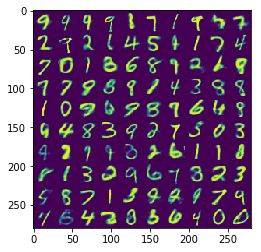

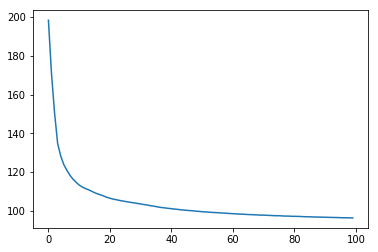

In [1]:
from vae import *
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt

# Define the identity function
def identity(x):
    return x

# Set up the network architecture
arch = dict()
arch['encoder'] = [\
    ('fc', identity, 784, -1), \
    ('fc', tf.nn.softplus, 500, 784), \
    ('fc', tf.nn.softplus, 500, 500), \
    ('fc', identity, 20, 500), \
    ('fc', identity, 20, 500) \
    ]
arch['decoder'] = [\
    ('fc', tf.nn.softplus, 500, 20), \
    ('fc', tf.nn.softplus, 500, 500), \
    ('fc', tf.nn.sigmoid, 784, 500) \
    ]
arch['input_shape'] = [784]
arch['first_roll_shape'] = (-1, -1, -1)

# Initialize the variational autoencoder
batch_size = 100
learning_rate = 1e-3
vae = VAE(arch, learning_rate, batch_size)

# Set up the data
mnist = input_data.read_data_sets('data/mnist/')

# Run the autoencoder
n_samples = mnist.train.num_examples
total_batch = int(n_samples/batch_size)
n_epochs = 100
display_step = 1

costs = []
for epoch in range(n_epochs):
    avg_cost = 0.0
    for batch in range(total_batch):
        x, _ = mnist.train.next_batch(batch_size)
        cost = vae.train(x)
        avg_cost += (cost - avg_cost) / (batch + 1)
    costs.append(avg_cost)

    if epoch % display_step == 0:
        print "\rEpoch:", '%04d' % (epoch+1), \
                "cost=", "{:.9f}".format(avg_cost),

# Generate sample images
z = np.random.normal(size=(batch_size, 20))
generated_images = vae.generate_image(z)

# Show generated images
big_image = np.zeros((280, 280))
for i in range(10):
    for j in range(10):
        n = i*10 + j
        big_image[28*i:28*(i+1), 28*j:28*(j+1)] = np.reshape(generated_images[n, :], (28, 28))

plt.imshow(big_image)
plt.show()

# Show cost vs epoch plot
plt.plot(costs)
plt.show()

The first figure above shows images that have been generated by the decoder network from random noise after training the variational autoencoder. It can be seen that the network generates almost real looking digits which in most cases can not be distinguished from handwritten digits using naked eye. The second plot shows the the negative of likelihood function with respect to the number of training epochs.

Convolutional neural networks usually perform better on vision related tasks as compared to standard fully connected MLPs by virtue of their architecture. In the next example we use a convolutional neural network both as an encoder and as a decoder (transposed convolutions are used in decoder). The dataset being used is still MNIST.

Extracting data/mnist/train-images-idx3-ubyte.gz
Extracting data/mnist/train-labels-idx1-ubyte.gz
Extracting data/mnist/t10k-images-idx3-ubyte.gz
Extracting data/mnist/t10k-labels-idx1-ubyte.gz
Epoch: 0150 cost= 99.1976605925                                                                                                                                                     

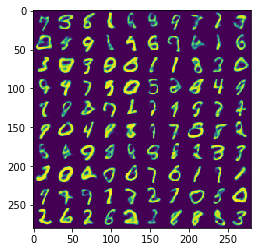

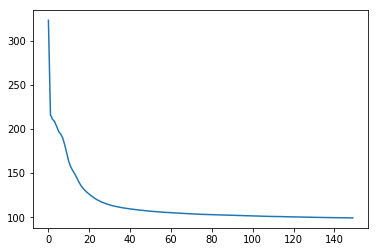

In [1]:
from vae import *
from tensorflow.examples.tutorials.mnist import input_data
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 100
learning_rate = 1e-4

# Define the identity function
def identity(x):
    return x

# Set up the network architecture
arch = dict()
arch['encoder'] = [\
    ('fc', identity, 784, -1), \
    ('conv', tf.nn.relu, 5, 1, 8), \
    ('conv', tf.nn.relu, 3, 8, 16), \
    ('pool', identity, 4), \
    ('fc', tf.nn.relu, 500, 784), \
    ('fc', identity, 20, 500), \
    ('fc', identity, 20, 500) \
    ]
arch['decoder'] = [\
    ('fc', tf.nn.relu, 500, 20), \
    ('fc', tf.nn.relu, 784, 500), \
    ('tconv', tf.nn.relu, 3, 16, 8, (batch_size, 14, 14, 8), (1, 2, 2, 1)), \
    ('tconv', tf.nn.sigmoid, 3, 8, 1, (batch_size, 28, 28, 1), (1, 2, 2, 1))
    ]
arch['input_shape'] = [28, 28, 1]
arch['first_roll_shape'] = (7, 7, 16)

# Initialize the variational autoencoder
vae = VAE(arch, learning_rate, batch_size)

# Set up the data
mnist = input_data.read_data_sets('data/mnist/')

# Run the autoencoder
n_samples = mnist.train.num_examples
total_batch = int(n_samples/batch_size)
n_epochs = 150
display_step = 1

costs = []
for epoch in range(n_epochs):
    avg_cost = 0.0
    for batch in range(total_batch):
        x, _ = mnist.train.next_batch(batch_size)
        x = np.reshape(x, (batch_size, 28, 28, 1))
        cost = vae.train(x)
        avg_cost += (cost - avg_cost) / (batch + 1)
    costs.append(avg_cost)

    if epoch % display_step == 0:
        print "\rEpoch:", '%04d' % (epoch+1), \
                "cost=", "{:.9f}".format(avg_cost),

# Generate sample images
z = np.random.normal(size=(batch_size, 20))
generated_images = vae.generate_image(z)

# Show generated images
big_image = np.zeros((280, 280))
for i in range(10):
    for j in range(10):
        n = i*10 + j
        big_image[28*i:28*(i+1), 28*j:28*(j+1)] = np.reshape(generated_images[n, :], (28, 28))

plt.imshow(big_image)
plt.show()

# Show cost vs epoch plot
plt.plot(costs)
plt.show()

## Experiment using CIFAR-10
We will next move on to another dataset called CIFAR-10. We will try to generate images which are like the images present in CIFAR-10 by training our variational autoencoder using this dataset. We will use a convolutional architecture for both encoder and decoder networks. ``read_cifar10.py`` is a helper file that reads the CIFAR-10 dataset. ``read_cifar10.py`` requires the location of CIFAR-10 data directory as input. The function ``get_data()`` returns a batch of images along with corresponding labels.

Reading data...
Data read.
Starting Training...
Epoch: 0150 cost= 1840.119207031                                                                                                                                                     

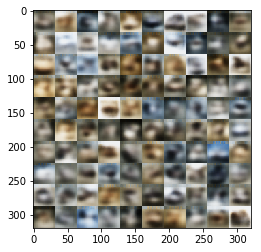

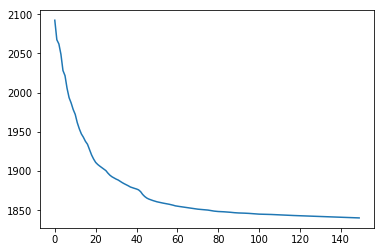

In [2]:
from vae import *
from read_cifar10 import *
import numpy as np
import matplotlib.pyplot as plt

# Hyperparameters
batch_size = 100
learning_rate = 1e-4

# Define the identity function
def identity(x):
    return x

# Set up the network architecture
arch = dict()
arch['encoder'] = [\
    ('fc', identity, 3072, -1), \
    ('conv', tf.nn.relu, 5, 3, 8), \
    ('conv', tf.nn.relu, 4, 8, 16), \
    ('pool', identity, 4), \
    ('fc', tf.nn.relu, 500, 1024), \
    ('fc', identity, 80, 500), \
    ('fc', identity, 80, 500) \
    ]
arch['decoder'] = [\
    ('fc', tf.nn.relu, 500, 80), \
    ('fc', tf.nn.relu, 1024, 500), \
    ('tconv', tf.nn.relu, 3, 16, 8, (batch_size, 16, 16, 8), (1, 2, 2, 1)), \
    ('tconv', tf.nn.sigmoid, 3, 8, 3, (batch_size, 32, 32, 3), (1, 2, 2, 1))
    ]
arch['input_shape'] = [32, 32, 3]
arch['first_roll_shape'] = (8, 8, 16)

# Initialize the variational autoencoder
vae = VAE(arch, learning_rate, batch_size)

# Set up the data
print 'Reading data...'
cifar = CIFAR10('data/cifar-10/')
print 'Data read.'

# Run the autoencoder
n_samples = cifar.get_num_training_examples()
total_batch = int(n_samples/batch_size)
n_epochs = 150
display_step = 1

costs = []
print 'Starting Training...'
for epoch in range(n_epochs):
    avg_cost = 0.0
    for batch in range(total_batch):
        x, _ = cifar.get_data(batch_size)
        x = np.ndarray.astype(x, np.float32) / 255.0
        cost = vae.train(x)
        avg_cost += (cost - avg_cost) / (batch + 1)
    costs.append(avg_cost)

    if epoch % display_step == 0:
        print "\rEpoch:", '%04d' % (epoch+1), \
                "cost=", "{:.9f}".format(avg_cost),

# Generate sample images
z = np.random.normal(size=(batch_size, 80))
generated_images = vae.generate_image(z)

# Show generated images
big_image = np.zeros((320, 320, 3))
for i in range(10):
    for j in range(10):
        n = i*10 + j
        big_image[32*i:32*(i+1), 32*j:32*(j+1), :] = np.reshape(generated_images[n, :], (32, 32, 3))

plt.imshow(big_image)
plt.show()

# Show cost vs epoch plot
plt.plot(costs)
plt.show()

It can be seen that the images that are generated by the variational autoencoder in this case are blurry. Although fine tuning the architecture usually leads to better results, the vanilla variational autoencoder usually produces blurry images. There are many modifications done to the basic variational autoencoder. For example, the DRAW network [Gregor et al. 2015](https://arxiv.org/pdf/1502.04623) employs attention mechanism on top of a variational autoencoder. Such models are beyond the scope of this project.